In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
        
            for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add total grazing fields
aggregates['TotalGrazing'] = {}
variables.append('TotalGrazing')
for year in years:
    aggregates['TotalGrazing'][year] = sum(aggregates[var][year] for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(aggregates['GRMESZDIAT'][2015][:]))

(898, 398)


In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']

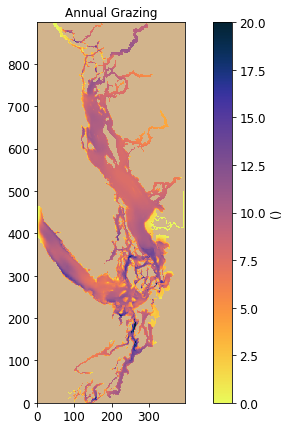

In [11]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=20
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing']['mean']*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Annual Grazing')
fig.colorbar(m0,ax=ax,label='()')



In [17]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-5
vmax=5

fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in Total Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

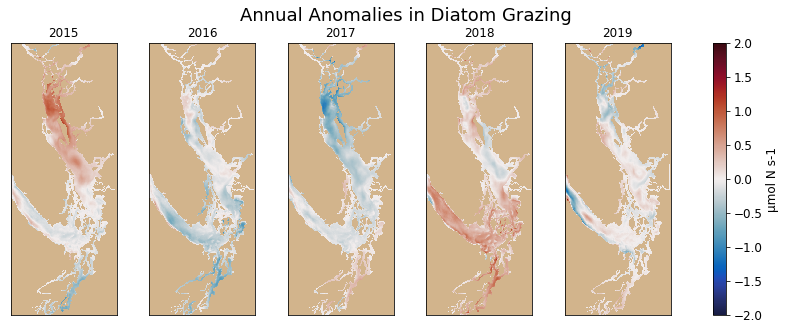

In [20]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-2
vmax=2

fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in Diatom Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZDIAT'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZDIAT'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZDIAT'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZDIAT'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZDIAT'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

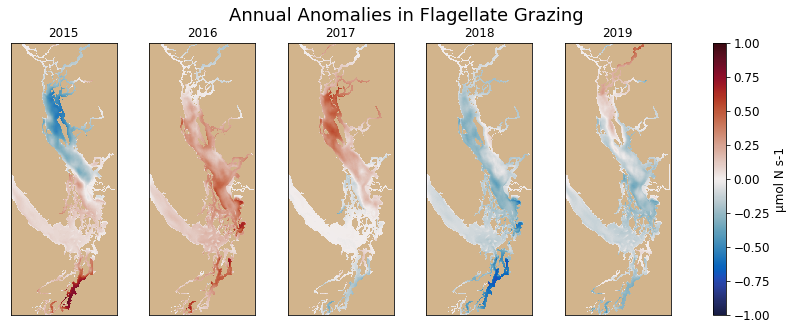

In [23]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-1
vmax=1


fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in Flagellate Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPHY'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPHY'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPHY'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPHY'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPHY'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

In [29]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-.25
vmax=.25


fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in Ciliate Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMRUB'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMRUB'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMRUB'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMRUB'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMRUB'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

In [31]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-1
vmax=1


fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in Microzooplankton Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMICZ'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMICZ'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMICZ'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMICZ'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZMICZ'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

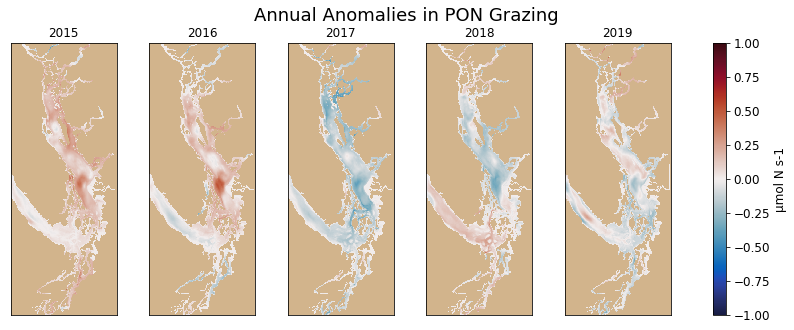

In [33]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-1
vmax=1


fig,ax=plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Annual Anomalies in PON Grazing', fontsize=18)


m0=ax[0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPON'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0],coords='grid')
ax[0].set_title('2015')
ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPON'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('2016')
ax[1].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPON'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[2],coords='grid')
ax[2].set_title('2017')
ax[2].yaxis.set_visible(False)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPON'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[3],coords='grid')
ax[3].set_title('2018')
ax[3].yaxis.set_visible(False)
ax[3].xaxis.set_visible(False)
ax[3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['GRMESZPON'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[4],coords='grid')
ax[4].set_title('2019')
ax[4].yaxis.set_visible(False)
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N s-1')

In [ ]:
#'GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ'

In [36]:

#years, months, data
monthly_array_diatoms_depthint_jdfslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZDIAT']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_diatoms_depthint_jdfslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZDIAT']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


<ipython-input-53-6f0c0c1d3cae>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_diatoms_depthint_jdfslice, axis = 2),axis = 2)


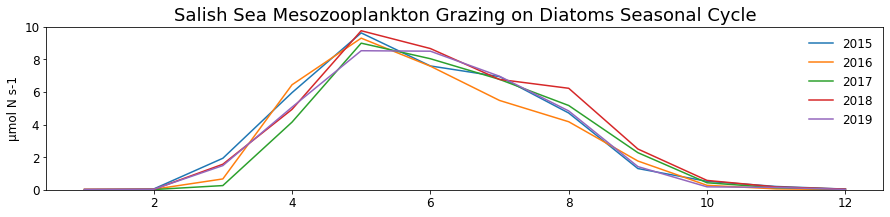

In [53]:
monthly_array_diatoms_depthint_jdfslice[monthly_array_diatoms_depthint_jdfslice == 0 ] = np.nan
monthly_array_diatoms_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_diatoms_depthint_jdfslice, axis = 2),axis = 2)
print(np.shape(monthly_array_diatoms_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13), monthly_array_diatoms_depthint_slicemean[i,:]*86400,label=2015+i)
    ax.set_title('Salish Sea Mesozooplankton Grazing on Diatoms Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,10)
    ax.set_ylabel('\u03bcmol N s-1')
   

In [41]:

#years, months, data
monthly_array_flag_depthint_jdfslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZPHY']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_flag_depthint_jdfslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZPHY']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


<ipython-input-55-5bf13453f3d1>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_flag_depthint_jdfslice, axis = 2),axis = 2)


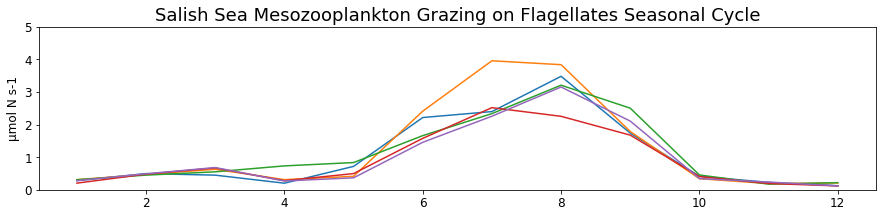

In [55]:
monthly_array_flag_depthint_jdfslice[monthly_array_flag_depthint_jdfslice == 0 ] = np.nan
monthly_array_flag_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_flag_depthint_jdfslice, axis = 2),axis = 2)
print(np.shape(monthly_array_flag_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13), monthly_array_flag_depthint_slicemean[i,:]*86400,label=2015+i)
    ax.set_title('Salish Sea Mesozooplankton Grazing on Flagellates Seasonal Cycle',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,5)
    ax.set_ylabel('\u03bcmol N s-1')

In [43]:

#years, months, data
monthly_array_ciliates_depthint_jdfslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZMRUB']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ciliates_depthint_jdfslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


<ipython-input-57-308ccb602b70>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_ciliates_depthint_jdfslice, axis = 2),axis = 2)


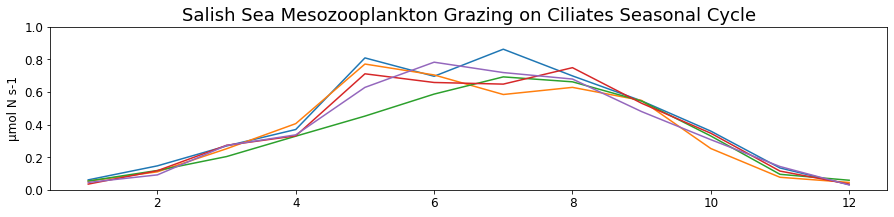

In [57]:
monthly_array_ciliates_depthint_jdfslice[monthly_array_ciliates_depthint_jdfslice == 0 ] = np.nan
monthly_array_ciliates_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_ciliates_depthint_jdfslice, axis = 2),axis = 2)
print(np.shape(monthly_array_ciliates_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13), monthly_array_ciliates_depthint_slicemean[i,:]*86400,label=2015+i)
    ax.set_title('Salish Sea Mesozooplankton Grazing on Ciliates Seasonal Cycle',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,1)
    ax.set_ylabel('\u03bcmol N s-1')

In [59]:

#years, months, data
monthly_array_micro_depthint_jdfslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZMICZ']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_micro_depthint_jdfslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZMICZ']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


<ipython-input-63-0f697b3ebfec>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_micro_depthint_jdfslice, axis = 2),axis = 2)


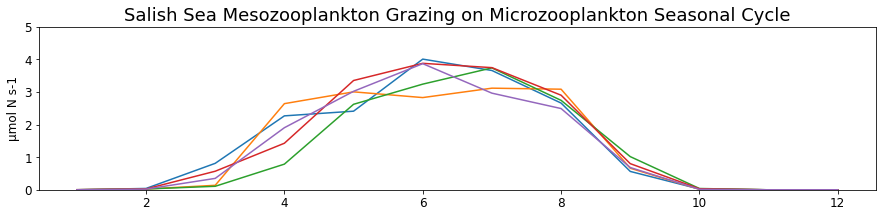

In [63]:
monthly_array_micro_depthint_jdfslice[monthly_array_micro_depthint_jdfslice == 0 ] = np.nan
monthly_array_micro_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_micro_depthint_jdfslice, axis = 2),axis = 2)
print(np.shape(monthly_array_micro_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13), monthly_array_micro_depthint_slicemean[i,:]*86400,label=2015+i)
    ax.set_title('Salish Sea Mesozooplankton Grazing on Microzooplankton Seasonal Cycle',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,5)
    ax.set_ylabel('\u03bcmol N s-1')

In [50]:

#years, months, data
monthly_array_PON_depthint_jdfslice = np.zeros([5,12,898,398])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMESZPON']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2015, 2016, 2017, 2018, 2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_PON_depthint_jdfslice[year-2015,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZPON']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





(5, 12)


<ipython-input-62-f892476f2b64>:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_PON_depthint_jdfslice, axis = 2),axis = 2)


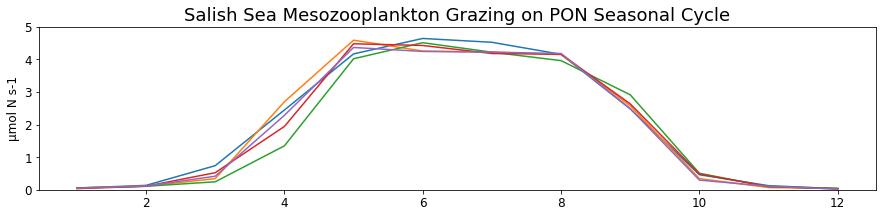

In [62]:
monthly_array_PON_depthint_jdfslice[monthly_array_PON_depthint_jdfslice == 0 ] = np.nan
monthly_array_PON_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_PON_depthint_jdfslice, axis = 2),axis = 2)
print(np.shape(monthly_array_PON_depthint_slicemean))


#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,5):
    ax.plot(np.arange(1,13), monthly_array_PON_depthint_slicemean[i,:]*86400,label=2015+i)
    ax.set_title('Salish Sea Mesozooplankton Grazing on PON Seasonal Cycle',fontsize=18)
    ax.legend((),frameon=False)
    ax.set_ylim(0,5)
    ax.set_ylabel('\u03bcmol N s-1')